In [17]:
%matplotlib inline
%load_ext cython
%load_ext autoreload
%autoreload 2

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os, sys
sys.path.append('/nfs/homes/sseyler/Projects/Methods/PSA/src/psa')
import psa

from MDAnalysis import Universe
from MDAnalysis.analysis.align import rotation_matrix
import numpy as np

# Display images from filesystem
from IPython.display import Image       # for PNGs
from wand.image import Image as WImage  # for PDFs

WORKDIR = '/nfs/homes/sseyler/Repositories/python/psanalysis'
# WORKDIR = '/Users/sseyler/Projects/Methods/PSA/src/psa'
sys.path.append(WORKDIR)

In [3]:
print("Generating AdK CORE C-alpha reference coords + structure...")
cref_filename = '%s/structs/1ake_a_ca_core.pdb' % WORKDIR
oref_filename = '%s/structs/4ake_a_ca_core.pdb' % WORKDIR

c_ref = Universe(cref_filename)
o_ref = Universe(oref_filename)
u_ref = Universe(cref_filename)

c_ref_ca = c_ref.selectAtoms('name CA')
o_ref_ca = o_ref.selectAtoms('name CA')

adkCORE_resids = "(resid 1:29 or resid 60:121 or resid 160:214)"
c_ref_CORE_ca = c_ref_ca.selectAtoms(adkCORE_resids).coordinates() \
        - c_ref_ca.selectAtoms(adkCORE_resids).centerOfMass()
o_ref_CORE_ca = o_ref_ca.selectAtoms(adkCORE_resids).coordinates() \
        - o_ref_ca.selectAtoms(adkCORE_resids).centerOfMass()
ref_coords = 0.5*(c_ref_CORE_ca + o_ref_CORE_ca)

u_ref.atoms.translate(-c_ref_ca.selectAtoms(adkCORE_resids).centerOfMass())
o_ref.atoms.translate(-o_ref_ca.selectAtoms(adkCORE_resids).centerOfMass())
u_ref.selectAtoms(adkCORE_resids).CA.set_positions(ref_coords)

Generating AdK CORE C-alpha reference coords + structure...


In [4]:
print("Building collection of simulations...")
# List of method names (same as directory names)
# method_names = ['DIMS', 'FRODA', 'MAP']
method_names = ['DIMS', 'FRODA', 'GOdMD', 'MDdMD', 'TMD-F', 'TMD-S',          \
                'ANMP', 'iENM', 'MAP', 'MENM-SD', 'MENM-SP',       \
                'Morph', 'LinInt']
# method_names = ['Morph', 'LinInt']
labels = [] # Heat map labels
simulations = [] # List of simulation topology/trajectory filename pairs

# Build list of simulations, each represented by a pair of filenames
# ([topology filename], [trajectory filename]). Generate corresponding label
# list.
for method in method_names:
    # Note: DIMS uses the PSF topology format
    topname = 'top.psf' if ('DIMS' in method or 'TMD' in method) else 'top.pdb'
    pathname = 'path.dcd'
    method_dir = '{}/methods/{}'.format(WORKDIR, method)
    if method is not 'LinInt':
        nruns = 3 if 'TMD' not in method else 3
#         if method == 'TMD-F':
#             for run in xrange(1, nruns+1): # 3 runs per method
#                 run_dir = '{}/{:03n}'.format(method_dir, run)
#                 topology = '{}/{}'.format(method_dir, topname)
#                 trajectory = '{}/{}'.format(run_dir, pathname)
#                 labels.append(method + '(' + str(run) + ')')
#                 simulations.append((topology, trajectory))
#         elif method == 'TMD-S':
#             for run in xrange(4, nruns+4): # 3 runs per method
#                 run_dir = '{}/{:03n}'.format(method_dir, run)
#                 topology = '{}/{}'.format(method_dir, topname)
#                 trajectory = '{}/{}'.format(run_dir, pathname)
#                 labels.append(method + '(' + str(run) + ')')
#                 simulations.append((topology, trajectory))
#         else:
        for run in xrange(1, nruns+1): # 3 runs per method
            run_dir = '{}/{:03n}'.format(method_dir, run)
            topology = '{}/{}'.format(method_dir, topname)
            trajectory = '{}/{}'.format(run_dir, pathname)
            if method == 'TMD-S':
                labels.append('rTMD-S(' + str(run) + ')')
            elif method == 'TMD-F':
                labels.append('rTMD-F(' + str(run) + ')')
            else:
                labels.append(method + '(' + str(run) + ')')
            simulations.append((topology, trajectory))
    else: # only one LinInt trajectory
        topology = '{}/{}'.format(method_dir, topname)
        trajectory = '{}/{}'.format(method_dir, pathname)
        labels.append(method)
        simulations.append((topology, trajectory))

Building collection of simulations...


In [5]:
# Generate simulation list represented as Universes. Each item, sim, in
# simulations is a topology/trajectory filename pair that is unpacked into
# an argument list with the "splat" ("*") operator.
universes = [] # List of MDAnalysis Universes representing simulations
for sim in simulations:
    if 'tmd' in trajectory:
        universes.append(Universe(*sim), format="LAMMPS")
    else:
        universes.append(Universe(*sim))

In [6]:
print("Initializing Path Similarity Analysis...")
ref_selection = "name CA and " + adkCORE_resids
psa_full = psa.PSA(universes, reference=u_ref, ref_select=ref_selection,
                    path_select="name CA", labels=labels)

Initializing Path Similarity Analysis...


In [7]:
print("Generating Path objects from aligned trajectories...")
psa_full.generate_paths(align=True, store=True)

/nfs/homes/sseyler/.local/lib/python2.7/site-packages/MDAnalysis/analysis/align.py:475: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  natoms, rot, weight)
Fitted frame   102/102  [100.0%]
Fitted frame    92/92  [100.0%]
Fitted frame    95/95  [100.0%]
Fitted frame   142/142  [100.0%]
Fitted frame   141/141  [100.0%]
Fitted frame   142/142  [100.0%]
Fitted frame    81/81  [100.0%]
Fitted frame   145/145  [100.0%]
Fitted frame   226/226  [100.0%]
Fitted frame    54/54  [100.0%]
Fitted frame    64/64  [100.0%]
Fitted frame    48/48  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   140/140  [100.0%]
Fitted frame   107/107  [100.0%]
Fitted frame   107/107  [100.0%]
Fitted frame   107/107  [100.0%]
Fitted frame    33/33  [100.0%]
Fitted frame    34/34  [100.0%]
Fitted frame    36/36  [100.0%]
Fitted 

Generating Path objects from aligned trajectories...


# =============================

In [8]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import cophenet, correspond, inconsistent, maxinconsts
import seaborn.apionly as sns
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from pylab import cm, savefig

In [10]:
metric = frechet
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'df_ward.pdf'

In [12]:
psa_full.run(metric=metric)
Z, dgram, d = psa_full.plot(filename=plotname, linkage=linkage);

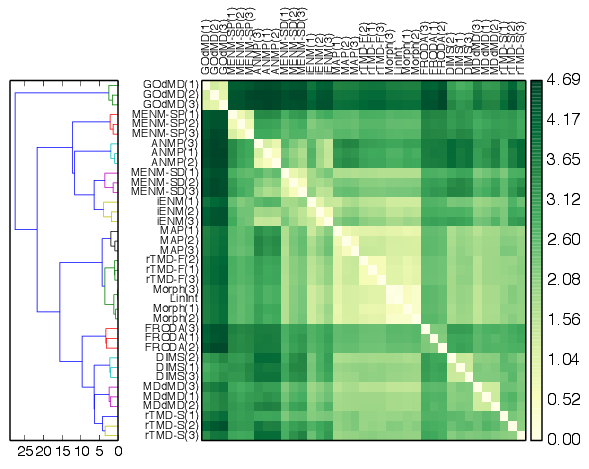

In [13]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
# Image(filename=(imgpath), width=650)     # Display PNG from filesystem
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [20]:
df_default = psa_full.D

In [18]:
np.set_printoptions(edgeitems=15, precision=1)

In [14]:
np.savetxt('/nfs/homes/sseyler/Projects/Methods/PSA/analysis/methods/data/psa/frechet_ward.dat', d)

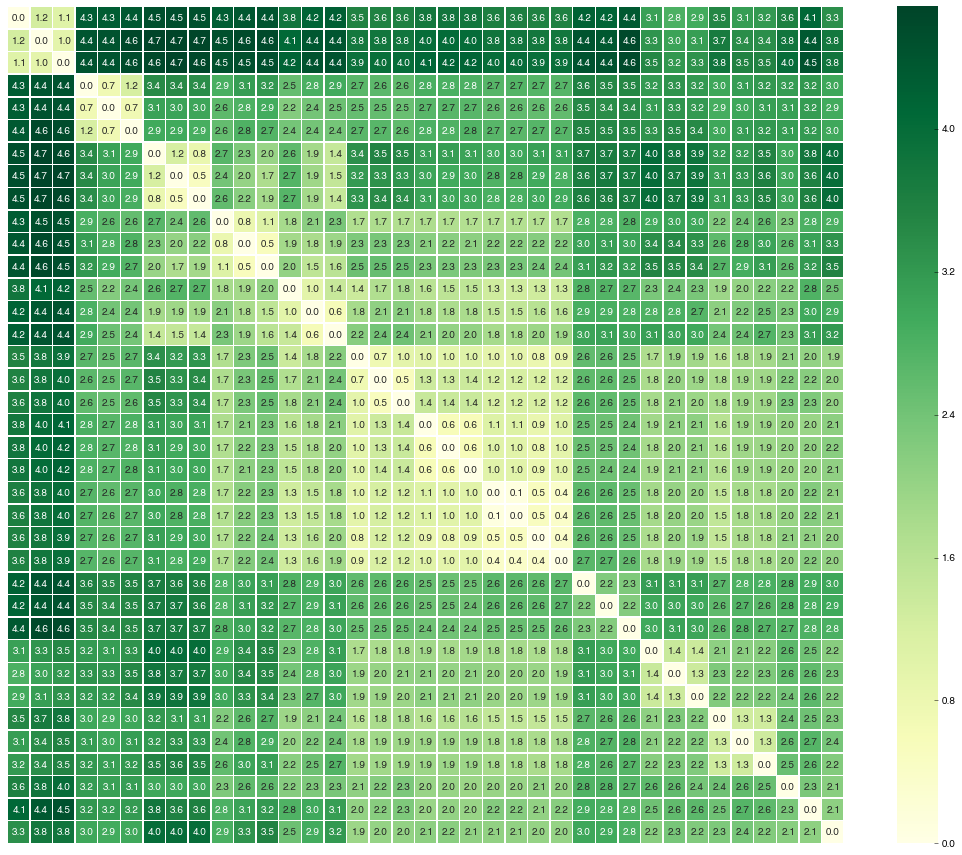

In [35]:
# im = sns.heatmap(df_default, annot=True, fmt='%6.1f', linewidths=0.5)
from matplotlib.pylab import figure
from pylab import cm

figsize, aspect = 15, 1.25
fig = figure(figsize=(figsize*aspect,figsize))
ax = fig.add_subplot(111)
ax = sns.heatmap(d, linewidths=0.25, cmap=cm.YlGn, annot=True, fmt='3.1f',
                     square=True, xticklabels=False, yticklabels=False, ax=ax)

for tic in ax.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
for tic in ax.xaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
for tic in ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    tic.label1On = tic.label2On = False
for tic in ax.yaxis.get_minor_ticks():
    tic.tick1On = tic.tick2On = False
            
plt.savefig('/nfs/homes/sseyler/Projects/Methods/PSA/analysis/methods/data/psa/frechet_ward_annot.pdf', dpi=600)

In [40]:
Y = squareform(psa_full.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)
print cor, c
print np.mean(maxc), np.mean(R[:,-1])
# print R

True 0.740510749535
0.584745927185 0.529643568915


In [10]:
metric = frechet
psa_full.run(metric=metric)

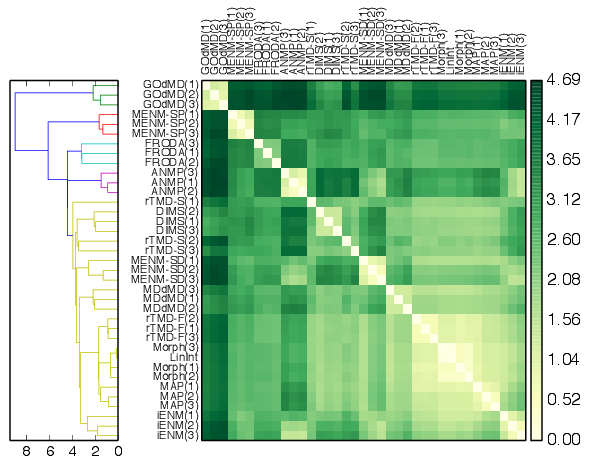

In [12]:
plotname = 'df_single_new.pdf'
Z, dgram = psa_full.plot(filename=plotname, linkage='single', figsize=4.5, labelsize=12,
                            distance_sort=False, count_sort=False)
Y = squareform(psa_full.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

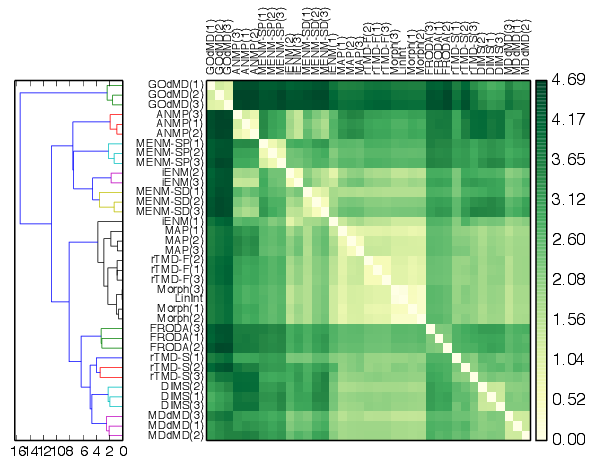

In [13]:
plotname = 'df_complete_new.pdf'
Z, dgram = psa_full.plot(filename=plotname, linkage='complete', figsize=4.5, labelsize=12,
                            distance_sort=False, count_sort=False)
Y = squareform(psa_full.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

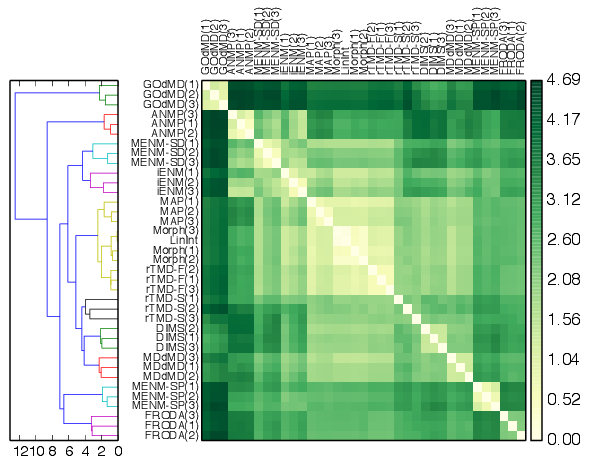

In [14]:
plotname = 'df_average_new.pdf'
Z, dgram = psa_full.plot(filename=plotname, linkage='average', figsize=4.5, labelsize=12,
                            distance_sort=False, count_sort=False)
Y = squareform(psa_full.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

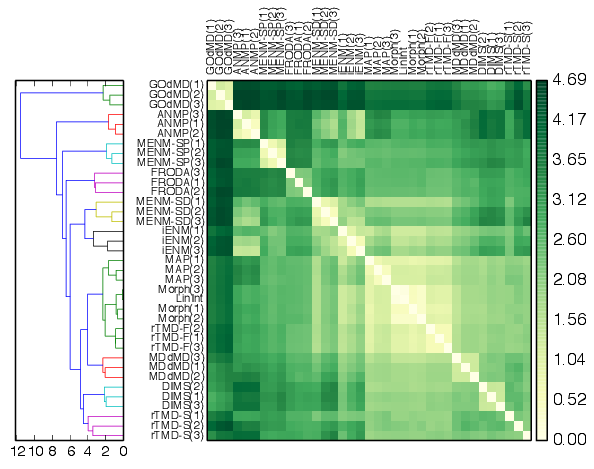

In [15]:
plotname = 'df_weighted_new.pdf'
Z, dgram = psa_full.plot(filename=plotname, linkage='weighted', figsize=4.5, labelsize=12,
                            distance_sort=False, count_sort=False)
Y = squareform(psa_full.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

---

---

In [20]:
# metric = 'hausdorff'
metric = hausdorff
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'dh_ward-new.pdf'

In [21]:
psa_full.run(metric=metric)
psa_full.plot(filename=plotname, linkage=linkage);

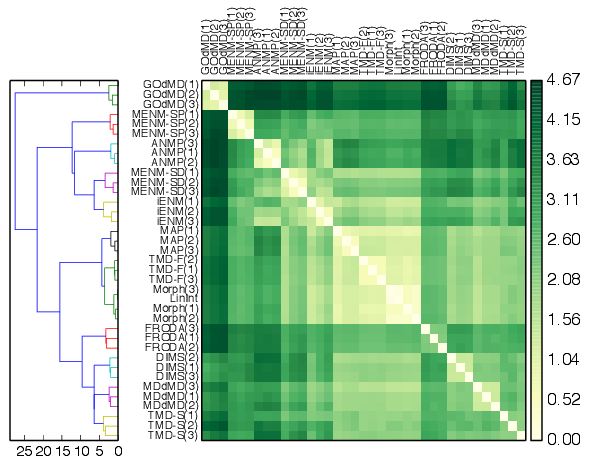

In [22]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
# Image(filename=(imgpath), width=650)     # Display PNG from filesystem
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [23]:
dh_default = psa_full.D

In [ ]:
Z, dgram = psa_methods.plot(filename='df_ward-withtmd.svg', linkage='ward', figsize=4.5, labelsize=12,
                            distance_sort=False, count_sort=False)
Y = squareform(psa_methods.D)
c, d = cophenet(Z, Y)
cor = correspond(Z, Y)
R = inconsistent(Z)
maxc = maxinconsts(Z, R)

---

In [24]:
# vdf = squareform(df_default)
vdh = squareform(dh_default)

In [52]:
np.max(np.abs(df_default-dh_default))

0.19468304440920203

In [26]:
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from pylab import cm, savefig

In [30]:
color = sns.color_palette()
color_set1 = sns.color_palette("Set1", 9)
color_set2 = sns.color_palette("Set2", 8)

In [55]:
datalen = len(vdf)
dframe = pd.DataFrame()
d = {'Discrete Fréchet' : vdf,
     'Hausdorff' : vdh}
dframe = dframe.append(pd.DataFrame(d))

In [67]:
plotname = 'psa_correlation.pdf'
color = sns.xkcd_rgb["denim blue"]
with sns.axes_style("darkgrid"):
    g = sns.jointplot('Discrete Fréchet', 'Hausdorff', data=dframe, kind="reg",
                      ratio=3, xlim=(0,5), ylim=(0,5), color=color, size=5);
    savefig('psadata/plots/' + plotname, dpi=600)

/nfs/homes/sseyler/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


In [ ]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [62]:
import matplotlib as mpl

mpl.use('agg')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex=False)

/nfs/homes/sseyler/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [79]:
plotname = 'psa_correlation'
color = color_set1[1]
with sns.axes_style("darkgrid"):
    sns.set_context('talk')
    g = sns.JointGrid('Discrete Fréchet', 'Hausdorff', dframe, size=3.75,
                      ratio=3, space=0.1, xlim=(0,5), ylim=(0,5))
    g.plot_marginals(sns.distplot, kde=True, color=color)
    g.plot_joint(plt.scatter, color=color, edgecolor="white", s=8)
    g.annotate(stats.pearsonr, template="{stat} = {val:.3f} (p = {p:.3g})",
              loc=4);
    savefig('psadata/plots/' + plotname + '.pdf', dpi=600)
    savefig('psadata/plots/' + plotname + '.png', dpi=600)
    savefig('psadata/plots/' + plotname + '.svg', dpi=600)

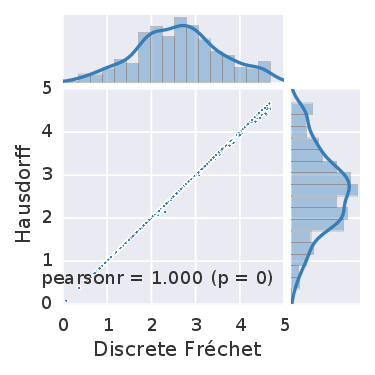

In [80]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname + '.pdf'
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

# =============================

# Hausdorff

In [16]:
%%cython -f -c=-Ofast -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport sqrt, fmax, fmin
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def hausdorff(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)

    return sqrt( fmax( np.amax(np.amin(d, axis=0)), np.amax(np.amin(d, axis=1)) ) / N  )

# Frechet

In [9]:
%%cython -f -c=-O3 -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport fmin, fmax, sqrt
cimport cython

ctypedef float (*cD_ptr)(float[:,::1], float[:,::1], np.intp_t, np.intp_t)

cdef float fmin3(float a, float b, float c):
    return fmin(fmin(a,b),c)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float cD(float[:,::1] d, float[:,::1] cd, np.intp_t i, np.intp_t j):
    cdef np.intp_t im1 = i-1
    cdef np.intp_t jm1 = j-1
    if cd[i,j] != -1 : return cd[i,j]
    if i > 0:
        if j > 0: cd[i,j] = fmax( fmin3(cD(d,cd,i,jm1),cD(d,cd,im1,jm1),cD(d,cd,im1,j)), d[i,j] )
        else:     cd[i,0] = fmax( cD(d,cd,im1,0), d[i,0] )
    elif j > 0:   cd[0,j] = fmax( cD(d,cd,0,jm1), d[0,j] )
    else:         cd[0,0] = d[0,0]
    return        cd[i,j]

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def frechet(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    cdef float[:,::1] cd = -np.ones((lenP, lenQ), dtype='float32')
    cdef cD_ptr couplingDistance = &cD

    return sqrt( couplingDistance(d, cd, lenP-1, lenQ-1) / N )

# Average Hausdorff

In [ ]:
%%cython -f -c=-Ofast -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport sqrt, fmax, fmin
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def hausdorff_avg2(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]

    return sqrt( (np.mean(np.amin(d, axis=0))/lenP + np.mean(np.amin(d, axis=1))/lenQ) / (p+q) / N )

In [28]:
%%cython -f -c=-Ofast -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport sqrt, fmax, fmin
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def hausdorff_avg(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    out = np.mean( np.append(np.amax(np.amin(d, axis=0)), np.amax(np.amin(d, axis=1))) )
    return sqrt( out / N )

In [8]:
%%cython -f -c=-Ofast -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport sqrt, fmax, fmin
import cython
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def hausdorff_wavg(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    out = 0.5*( np.mean(np.amin(d, axis=0))
              + np.mean(np.amin(d, axis=1)) )
    return sqrt( out / N )

In [17]:
metric = hausdorff_wavg
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'dh-wavg_ward.pdf'

In [18]:
psa_full.run(metric=metric)
Z, dgram = psa_full.plot(filename=plotname, linkage=linkage);

In [ ]:
vdh_wavg = squareform(psa_full.D)

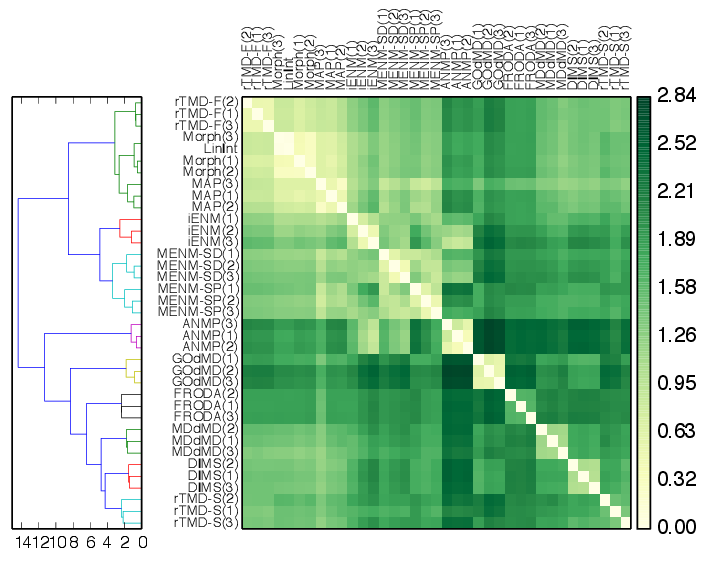

In [20]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=120) # Display PDF from filesystem

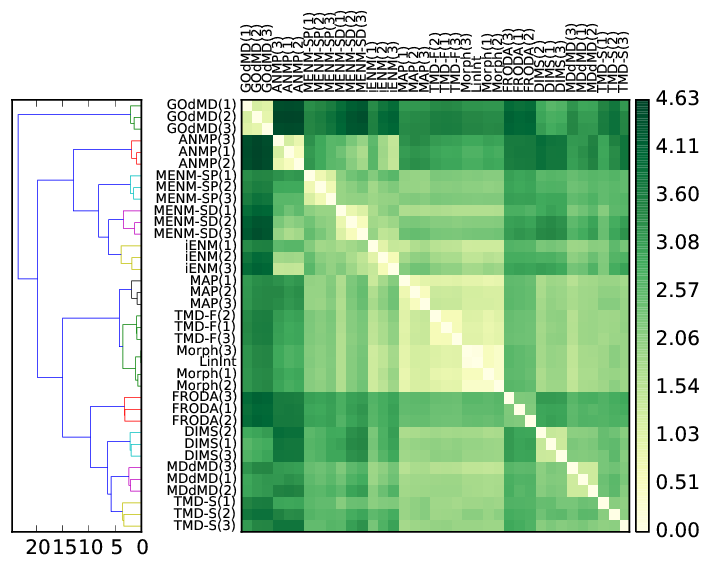

In [26]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=120) # Display PDF from filesystem

# Average Frechet

In [129]:
metric = frechet_avg
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'df-avg_ward.pdf'

In [130]:
psa_full.run(metric=metric)
Z, dgram = psa_full.plot(filename=plotname, linkage=linkage);

## Maximum-link-length (original) coupling distance function

In [ ]:
def c(i, j):
    if ca[i,j] != -1 : return ca[i,j]
    if i > 0:
        if j > 0: ca[i,j] = max( min(c(i-1,j),c(i,j-1),c(i-1,j-1)), d[i,j] )
        else:     ca[i,j] = max( c(i-1,0), d[i,0] )
    elif j > 0:   ca[i,j] = max( c(0,j-1), d[0,j] )
    else:         ca[i,j] = d[0,0]
    return        ca[i,j]

## Average-link-length coupling distance function

In [145]:
%%cython -f -c=-O3 -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport fmin, fmax, sqrt
cimport cython

ctypedef float[::1] (*c_ptr)(float[:,::1], float[:,:,::1], np.intp_t, np.intp_t)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[::1] c(float[:,::1] d, float[:,:,::1] cd, np.intp_t i, np.intp_t j):
    cdef np.intp_t im1, jm1
    cdef float[::1] cim1j, cijm1, cim1jm1 = np.empty((2,), dtype='float32')
    im1 = i-1
    jm1 = j-1
    if cd[i,j,0] != -1 : return cd[i,j,:]
    if i > 0:
        if j > 0:
            cim1j = c(d,cd,i-1,j)
            cijm1 = c(d,cd,i,j-1)
            cim1jm1 = c(d,cd,i-1,j-1)
            if cim1j[0] < cijm1[0]:
                if cim1j[0] < cim1jm1[0]:
                    cd[i,j,1] = cim1j[1] + 1
                    cd[i,j,0] = (cim1j[1]*cim1j[0] + d[i,j])/cd[i,j,1]
                else:
                    cd[i,j,1] = cim1jm1[1] + 1
                    cd[i,j,0] = (cim1jm1[1]*cim1jm1[0] + d[i,j])/cd[i,j,1]
            elif cijm1[0] < cim1jm1[0]:
                cd[i,j,1] = cijm1[1] + 1
                cd[i,j,0] = (cijm1[1]*cijm1[0] + d[i,j])/cd[i,j,1]
            else:
                cd[i,j,1] = cim1jm1[1] + 1
                cd[i,j,0] = (cim1jm1[1]*cim1jm1[0] + d[i,j])/cd[i,j,1]
        else:
            cim1j = c(d,cd,i-1,j)
            cd[i,j,1] = cim1j[1] + 1
            cd[i,j,0] = (cim1j[1]*cim1j[0] + d[i,j])/cd[i,j,1]
#             cd[i,j,0] = (i*cim1j[0] + d[i,j])/(i+1)
    elif j > 0:
        cijm1 = c(d,cd,i,j-1)
        cd[i,j,1] = cijm1[1] + 1
        cd[i,j,0] = (cijm1[1]*cijm1[0] + d[i,j])/cd[i,j,1]
#         cd[i,j,0] = (j*cijm1[0] + d[i,j])/(j+1)
    else:
        cd[i,j,1] = 1
        cd[i,j,0] = d[i,j]
    return cd[i,j,:]

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def frechet_avg(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    cdef float[:,:,::1] cd = -np.ones((lenP, lenQ, 2), dtype='float32')
    cdef c_ptr couplingDistance = &c
    cdef float[::1] cdcl = np.empty((2,), dtype='float32')
    
    cdcl = couplingDistance(d, cd, lenP-1, lenQ-1)
    return sqrt( cdcl[0] / N )

In [21]:
%%cython -f -c=-Ofast -c=-funroll-loops -c=-ffast-math -c=-march=native
import numpy as np
cimport numpy as np
from libc.math cimport fmin, fmax, sqrt
cimport cython

ctypedef float[::1] (*c_ptr)(float[:,::1], float[:,:,::1], np.intp_t, np.intp_t)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[::1] c(float[:,::1] d, float[:,:,::1] cd, np.intp_t i, np.intp_t j):
    cdef np.intp_t im1, jm1
    cdef float[::1] cim1j, cijm1, cim1jm1 = np.empty((2,), dtype='float32')
    cdef float cd_im1j, cd_ijm1, cd_im1jm1
    cdef float cl_im1j, cl_ijm1, cl_im1jm1
    cdef float cd_im1j_new, cd_ijm1_new, cd_im1jm1_new
    im1 = i-1
    jm1 = j-1
    if cd[i,j,0] != -1 : return cd[i,j,:]
    if i > 0:
        if j > 0:
            cim1j = c(d,cd,im1,j)
            cijm1 = c(d,cd,i,jm1)
            cim1jm1 = c(d,cd,im1,jm1)
            cd_im1j = cim1j[0]
            cl_im1j = cim1j[1]
            cd_ijm1 = cijm1[0]
            cl_ijm1 = cijm1[1]
            cd_im1jm1 = cim1jm1[0]
            cl_im1jm1 = cim1jm1[1]
            
            cd_im1j_new = (cd_im1j*cl_im1j + d[i,j])/(cl_im1j + 1)
            cd_ijm1_new = (cd_ijm1*cl_ijm1 + d[i,j])/(cl_ijm1 + 1)
            cd_im1jm1_new = (cd_im1jm1*cl_im1jm1 + d[i,j])/(cl_im1jm1 + 1)
            
            if cd_im1j_new < cd_ijm1_new:
                if cd_im1j_new < cd_im1jm1_new:
                    cd[i,j,1] = cl_im1j + 1
                    cd[i,j,0] = cd_im1j_new
                else:
                    cd[i,j,1] = cl_im1jm1 + 1
                    cd[i,j,0] = cd_im1jm1_new
            elif cd_ijm1_new < cd_im1jm1_new:
                cd[i,j,1] = cl_ijm1 + 1
                cd[i,j,0] = cd_ijm1_new
            else:
                cd[i,j,1] = cl_im1jm1 + 1
                cd[i,j,0] = cd_im1jm1_new
        else:
            cim1j = c(d,cd,im1,j)
            cd[i,j,1] = cim1j[1] + 1
            cd[i,j,0] = (i*cim1j[0] + d[i,j])/(i+1)
    elif j > 0:
        cijm1 = c(d,cd,i,jm1)
        cd[i,j,1] = cijm1[1] + 1
        cd[i,j,0] = (j*cijm1[0] + d[i,j])/(j+1)
    else:
        cd[i,j,1] = 1
        cd[i,j,0] = d[i,j]
    return cd[i,j,:]

@cython.boundscheck(False)
@cython.wraparound(False)
cdef float[:,::1] rmsdMatrix_c(float[:,::1] P, float[:,::1] Q):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    cdef np.intp_t i, j, k
    cdef float s, diff
    cdef float[:,::1] d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

@cython.boundscheck(False)
@cython.wraparound(False)
def frechet_avg_fixed(float[:,::1] P, float[:,::1] Q, np.intp_t N):
    cdef np.intp_t lenP = P.shape[0]
    cdef np.intp_t lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    cdef float[:,::1] d = rmsdMatrix_c(P, Q)
    cdef float[:,:,::1] cd = -np.ones((lenP, lenQ, 2), dtype='float32')
    cdef c_ptr couplingDistance = &c
    cdef float[::1] cdcl = np.empty((2,), dtype='float32')
    
    cdcl = couplingDistance(d, cd, lenP-1, lenQ-1)
    return sqrt( cdcl[0] / N )

In [22]:
metric = frechet_avg_fixed
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'df-avg-fixed_ward.pdf'

In [23]:
psa_full.run(metric=metric)
Z, dgram = psa_full.plot(filename=plotname, linkage=linkage);

In [37]:
vdf_avg = squareform(psa_full.D)

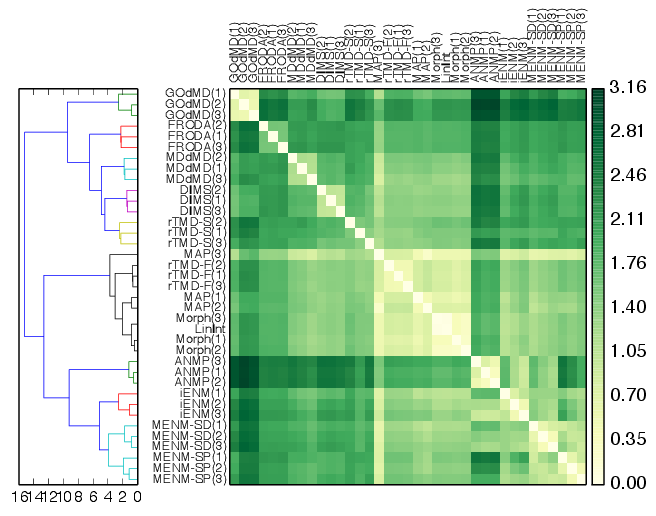

In [24]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=110) # Display PDF from filesystem

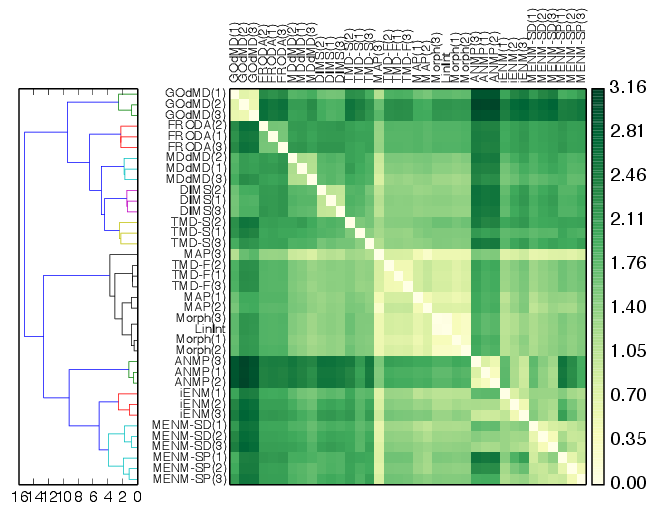

In [148]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=110) # Display PDF from filesystem

# =============================

## Correlation plots for average-type path metrics

In [25]:
import matplotlib as mpl

mpl.use('agg')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex=False)

/nfs/homes/sseyler/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [39]:
datalen = len(vdf_avg)
dframe = pd.DataFrame()
d = {'Average Discrete Fréchet' : vdf_avg,
     'Average Hausdorff' : vdh_avg}
dframe = dframe.append(pd.DataFrame(d))

In [40]:
plotname = 'psa_correlation_df-avg_vs_dh-avg.pdf'
color = sns.xkcd_rgb["denim blue"]
with sns.axes_style("darkgrid"):
    g = sns.jointplot('Average Discrete Fréchet', 'Average Hausdorff', data=dframe, kind="reg",
                      ratio=3, xlim=(0,5), ylim=(0,5), color=color, size=5);
    savefig('psadata/plots/' + plotname, dpi=600)

In [42]:
plotname = 'psa_correlation_df-avg_vs_dh-avg'
color = color_set1[1]
with sns.axes_style("darkgrid"):
    sns.set_context('talk')
    g = sns.JointGrid('Average Discrete Fréchet', 'Average Hausdorff', dframe, size=3.75,
                      ratio=3, space=0.1, xlim=(0,5), ylim=(0,5))
    g.plot_marginals(sns.distplot, kde=True, color=color)
    g.plot_joint(plt.scatter, color=color, edgecolor="white", s=8)
    g.annotate(stats.pearsonr, template="{stat} = {val:.3f} (p = {p:.3g})",
              loc=4);
    savefig('psadata/plots/' + plotname + '.pdf', dpi=600)
    savefig('psadata/plots/' + plotname + '.png', dpi=600)
    savefig('psadata/plots/' + plotname + '.svg', dpi=600)

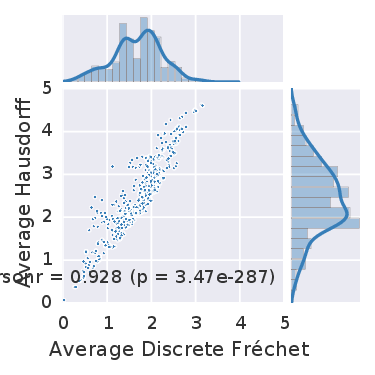

In [43]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname + '.pdf'
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [63]:
vdf = squareform(df_default)
vdh = squareform(dh_default)

In [64]:
datalen = len(vdf_avg)
dframe = pd.DataFrame()
d = {'Discrete Fréchet' : vdf,
     'Average Discrete Fréchet' : vdf_avg}
dframe = dframe.append(pd.DataFrame(d))

In [66]:
plotname = 'psa_correlation_df_vs_df-avg'
color = color_set1[1]
with sns.axes_style("darkgrid"):
    sns.set_context('talk')
    g = sns.JointGrid('Discrete Fréchet', 'Average Discrete Fréchet', dframe, size=3.75,
                      ratio=3, space=0.1, xlim=(0,5), ylim=(0,5))
    g.plot_marginals(sns.distplot, kde=True, color=color)
    g.plot_joint(plt.scatter, color=color, edgecolor="white", s=8)
    g.annotate(stats.pearsonr, template="{stat} = {val:.3f} (p = {p:.3g})",
              loc=4);
    savefig('psadata/plots/' + plotname + '.pdf', dpi=600)
    savefig('psadata/plots/' + plotname + '.png', dpi=600)
    savefig('psadata/plots/' + plotname + '.svg', dpi=600)

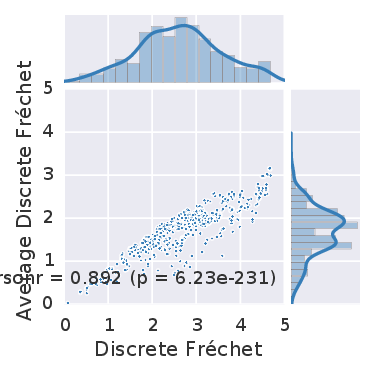

In [67]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname + '.pdf'
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [68]:
datalen = len(vdh_avg)
dframe = pd.DataFrame()
d = {'Hausdorff' : vdh,
     'Average Hausdorff' : vdh_avg}
dframe = dframe.append(pd.DataFrame(d))

In [70]:
plotname = 'psa_correlation_dh_vs_dh-avg'
color = color_set1[1]
with sns.axes_style("darkgrid"):
    sns.set_context('talk')
    g = sns.JointGrid('Hausdorff', 'Average Hausdorff', dframe, size=3.75,
                      ratio=3, space=0.1, xlim=(0,5), ylim=(0,5))
    g.plot_marginals(sns.distplot, kde=True, color=color)
    g.plot_joint(plt.scatter, color=color, edgecolor="white", s=8)
    g.annotate(stats.pearsonr, template="{stat} = {val:.3f} (p = {p:.3g})",
              loc=4);
    savefig('psadata/plots/' + plotname + '.pdf', dpi=600)
    savefig('psadata/plots/' + plotname + '.png', dpi=600)
    savefig('psadata/plots/' + plotname + '.svg', dpi=600)

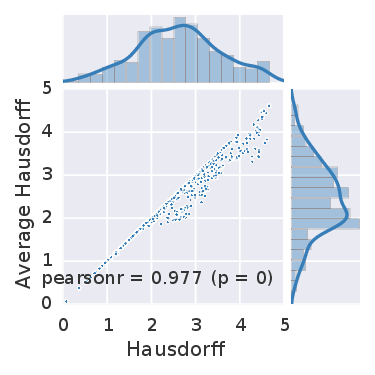

In [71]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname + '.pdf'
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

In [28]:
datalen = len(vdh_wavg)
dframe = pd.DataFrame()
d = {'Hausdorff' : vdh,
     'Weighted Average Hausdorff' : vdh_wavg}
dframe = dframe.append(pd.DataFrame(d))

In [31]:
plotname = 'psa_correlation_dh_vs_dh-wavg'
color = color_set1[1]
with sns.axes_style("darkgrid"):
    sns.set_context('talk')
    g = sns.JointGrid('Hausdorff', 'Weighted Average Hausdorff', dframe, size=3.75,
                      ratio=3, space=0.1, xlim=(0,5), ylim=(0,5))
    g.plot_marginals(sns.distplot, kde=True, color=color)
    g.plot_joint(plt.scatter, color=color, edgecolor="white", s=8)
    g.annotate(stats.pearsonr, template="{stat} = {val:.3f} (p = {p:.3g})",
              loc=4);
    savefig('psadata/plots/' + plotname + '.pdf', dpi=600)
    savefig('psadata/plots/' + plotname + '.png', dpi=600)
    savefig('psadata/plots/' + plotname + '.svg', dpi=600)

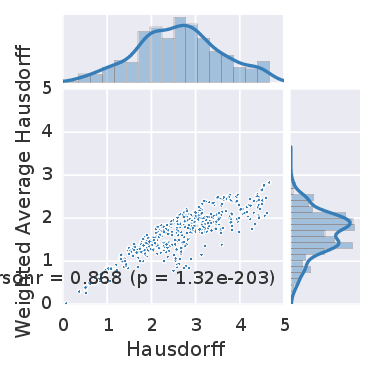

In [32]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname + '.pdf'
WImage(filename=(imgpath), resolution=100) # Display PDF from filesystem

# =============================

In [119]:
import numpy as np

def rmsdMatrix_c(P, Q):
    lenP = P.shape[0]
    lenQ = Q.shape[0]
    d = np.empty((lenP, lenQ), dtype='float32')
    for i in xrange(lenP):
        for j in xrange(lenQ):
            s = 0.0
            for k in xrange(P.shape[1]):
                diff = P[i,k] - Q[j,k]
                s += diff*diff
            d[i,j] = s
    return d

def c(d, cd, i, j):
    if cd[i,j,0] != -1 : return cd[i,j,:]
    if i > 0:
        if j > 0:
            cim1j = c(d,cd,i-1,j)
            cijm1 = c(d,cd,i,j-1)
            cim1jm1 = c(d,cd,i-1,j-1)
#                 print "0: i>0, j>0 | %i, %i: %i %i %i" % (i,j, cim1j[1], cijm1[1], cim1jm1[1])
            if cim1j[0] < cijm1[0]:
                if cim1j[0] < cim1jm1[0]:
                    cd[i,j,1] = cim1j[1] + 1
                    cd[i,j,0] = (cim1j[1]*cim1j[0] + d[i,j])/cd[i,j,1]
#                         print "1: i>0, j>0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
                else:
                    cd[i,j,1] = cim1jm1[1] + 1
                    cd[i,j,0] = (cim1jm1[1]*cim1jm1[0] + d[i,j])/cd[i,j,1]
#                         print "3: i>0, j>0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
            elif cijm1[0] < cim1jm1[0]:
                cd[i,j,1] = cijm1[1] + 1
                cd[i,j,0] = (cijm1[1]*cijm1[0] + d[i,j])/cd[i,j,1]
#                     print "2: i>0, j>0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
            else:
                cd[i,j,1] = cim1jm1[1] + 1
                cd[i,j,0] = (cim1jm1[1]*cim1jm1[0] + d[i,j])/cd[i,j,1]
#                     print "3: i>0, j>0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
        else:
            cim1j = c(d,cd,i-1,j)
            cd[i,j,1] = cim1j[1] + 1
            cd[i,j,0] = (i*cim1j[0] + d[i,j])/(i+1)
#                 print "   i>0, j=0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
    elif j > 0:
        cijm1 = c(d,cd,i,j-1)
        cd[i,j,1] = cijm1[1] + 1
        cd[i,j,0] = (j*cijm1[0] + d[i,j])/(j+1)
#             print "   i=0, j>0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
    else:
        cd[i,j,1] = 1
        cd[i,j,0] = d[i,j]
#             print "   i=0, j=0 | %i, %i: %3.1f %i" % (i,j, cd[i,j], cl[i,j])
    return cd[i,j,:]

def frechet_avg2(P, Q, N):
    lenP = P.shape[0]
    lenQ = Q.shape[0]
    assert (int(P.shape[1]) == int(3*N) and P.shape[1] == Q.shape[1])
    d = rmsdMatrix_c(P, Q)
    cd = -np.ones((lenP, lenQ, 2), dtype='float32')
#     cl = -np.ones((lenP, lenQ), dtype='int32')
    
    cdcl = c(d, cd, lenP-1, lenQ-1)
    return np.sqrt( cdcl[0] / N )

In [120]:
metric = frechet_avg2
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'df-avg_ward.pdf'

In [121]:
psa_full.run(metric=metric)
Z, dgram = psa_full.plot(filename=plotname, linkage=linkage);

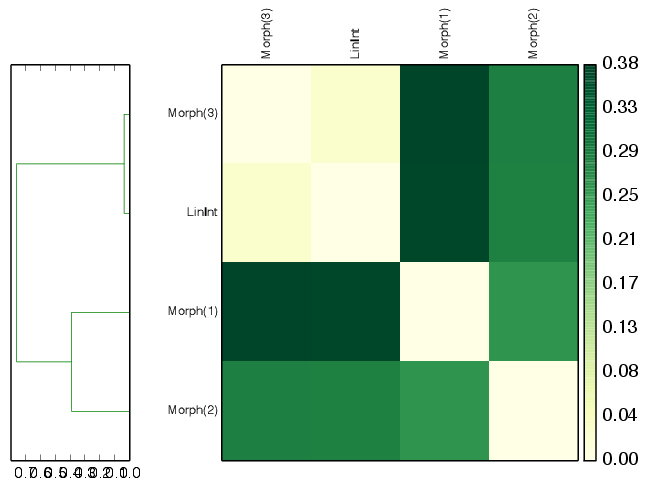

In [112]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=110) # Display PDF from filesystem

In [129]:
metric = frechet_avg
linkage = 'ward' # 'single' 'complete' 'weighted' 'average'
plotname = 'df-avg_ward.pdf'

In [130]:
psa_full.run(metric=metric)
Z, dgram = psa_full.plot(filename=plotname, linkage=linkage);

## TEST OF CYTHON AVG FRECHET... WORKS!!!

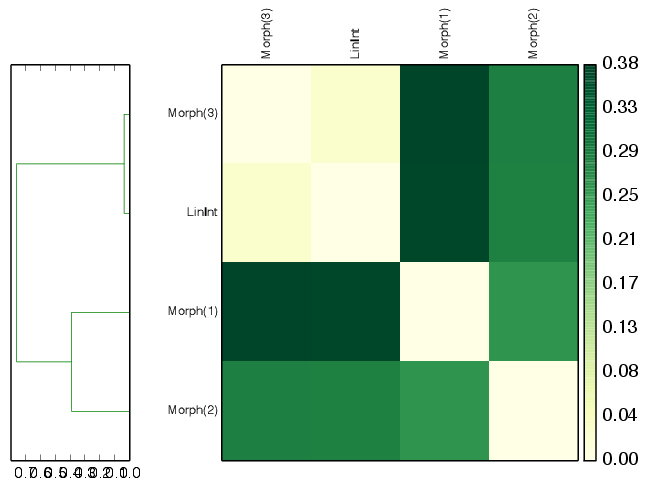

In [131]:
imgpath = WORKDIR+ '/source/core/psadata/plots/' + plotname
WImage(filename=(imgpath), resolution=110) # Display PDF from filesystem